# End to End Test Results

This notebook parses results from end-to-end testing as documented in [tile-benchmarking/e2e/e2e.ipynb](https://github.com/developmentseed/tile-benchmarking/blob/main/e2e/e2e.ipynb).

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define the data location

In [2]:
git_url_path = "https://raw.githubusercontent.com/developmentseed/tile-benchmarking/main/e2e"

## Define some helper functions

In [3]:
def generate_zooms_plot(df, dataset):
    zooms = [int(path.split('/')[2]) for path in df['Name'][:-1]]
    # Create a new figure
    plt.figure()

    # Create a scatter plot
    plt.scatter(zooms, df['Median Response Time'][:-1])

    # Add title and labels
    plt.title(dataset)
    plt.xlabel('Zoom')
    plt.ylabel('Time (ms)')

    # Display the plot
    plt.show() 
    
def git_url(filename):
    return f'{git_url_path}/{filename}'

def add_to_specs(collection_name: str, df: pd.DataFrame):
    zarr_specs.loc[collection_name, 'mean median response time'] = np.mean(df['Median Response Time'][1:])
    zarr_specs.loc[collection_name, 'median median response time'] = np.median(df['Median Response Time'][1:])   

## Parse collection results into a data frame

Which also has the specs of the data, such as chunk size.

In [4]:
zarr_specs = pd.read_csv(f"{git_url_path}/zarr_info.csv")
zarr_specs.index = zarr_specs['collection_name']

for collection_name in zarr_specs.index:
    filename = f'results/{collection_name}_urls_stats.csv'
    results_df = pd.read_csv(git_url(filename))
    add_to_specs(collection_name, results_df)

# Review the results

Mean median response time represents the average median response time for all tiles tested, minus the first tile since the first tile request tended to be an outlier. Tested tiles ranged from zoom 0 to zoom 7. From testing we noticed that the most important factors in determining response time were the number of coordinate chunks and the chunk size.

**Based on this, the recommendation would be to create chunks as small as possible (e.g. 1 timestep per chunk if visualization is the main goal) and not to chunk coordinate data.**

However more testing on a high resolution dataset is needed to determine when data should be chunked spatially to deliver good performance. For example, the gpm3imergdl has large chunks because all spatial data is stored in one chunk, but each chunk also has 10 time steps. If each chunk had 1 timestep, each chunk would be ~24.7MB. How would this compare with the performance of the same dataset, chunked spatially into even smaller chunks?

TODO: Revisit the zoom 0 statement, since the first request was always to the 0/0/0 tile.

In [5]:
zarr_specs[
    ['shape', 'chunks', 'chunk_size_mb', 'number_coord_chunks', 'mean median response time']
].sort_values('mean median response time', ascending=False)

,shape,chunks,chunk_size_mb,number_coord_chunks,mean median response time
collection_name,,,,,
CMIP6_daily_GISS-E2-1-G_tas-600_1440_1,"{'time': 730, 'lat': 600, 'lon': 1440}","{'time': 1, 'lat': 600, 'lon': 1440}",3.295898,732,2132.982857
gpm3imergdl,"{'time': 8149, 'lon': 3600, 'lat': 1800}","{'time': 10, 'lon': 3600, 'lat': 1800}",247.192383,3,2021.094272
CMIP6_daily_GISS-E2-1-G_tas-600_1440_29,"{'time': 730, 'lat': 600, 'lon': 1440}","{'time': 29, 'lat': 600, 'lon': 1440}",95.581055,27,652.554858
CMIP6_daily_GISS-E2-1-G_tas-365_262_262,"{'time': 730, 'lat': 600, 'lon': 1440}","{'time': 365, 'lat': 262, 'lon': 262}",95.577469,9,641.327968
CMIP6_GISS-E2-1-G_historical,"{'time': 1980, 'lat': 90, 'lon': 144}","{'time': 600, 'lat': 90, 'lon': 144}",29.663086,3,582.263112
power_901_monthly_meteorology_utc,"{'time': 492, 'lat': 361, 'lon': 576}","{'time': 492, 'lat': 25, 'lon': 25}",2.346039,43,482.190977
aws-noaa-oisst-avhrr-only,"{'time': 15044, 'zlev': 1, 'lat': 720, 'lon': ...","{'time': 1, 'zlev': 1, 'lat': 720, 'lon': 1440}",1.977539,4,468.469388
CMIP6_daily_GISS-E2-1-G_tas-no-coord-chunks,"{'time': 730, 'lat': 600, 'lon': 1440}","{'time': 1, 'lat': 600, 'lon': 1440}",3.295898,3,295.876289
FWI-GEOS-5-Hourly,"{'time': 26880, 'lat': 533, 'lon': 1152}","{'time': 120, 'lat': 100, 'lon': 100}",4.577637,3,291.349429


# Read results for a specific dataset

In [8]:
# Can replace with any of the collection names
collection_name = 'CMIP6_daily_GISS-E2-1-G_tas-600_1440_29'
filename = f'results/{collection_name}_urls_stats.csv'
results_df = pd.read_csv(git_url(filename))
results_df

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,GET,/tiles/0/0/0.png?reference=False&variable=tas&...,5,0,870.000000,923.172460,751.086928,1287.539062,15213.000000,0.037808,...,910,910,1300,1300,1300,1300,1300,1300,1300,1300
1,GET,/tiles/1/1/1.png?reference=False&variable=tas&...,5,0,660.000000,679.218529,630.763268,747.653087,4205.000000,0.037808,...,710,710,750,750,750,750,750,750,750,750
2,GET,/tiles/2/1/0.png?reference=False&variable=tas&...,5,0,718.190083,682.237738,617.691987,718.190083,7938.000000,0.037808,...,720,720,720,720,720,720,720,720,720,720
3,GET,/tiles/2/2/0.png?reference=False&variable=tas&...,5,0,680.000000,668.356649,616.550261,699.007727,4622.000000,0.037808,...,700,700,700,700,700,700,700,700,700,700
4,GET,/tiles/2/2/1.png?reference=False&variable=tas&...,5,0,730.000000,715.058600,664.841387,756.583840,25985.000000,0.037808,...,740,740,760,760,760,760,760,760,760,760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,GET,/tiles/7/8/23.png?reference=False&variable=tas...,5,0,720.000000,696.424204,626.454098,769.893036,693.000000,0.037808,...,730,730,770,770,770,770,770,770,770,770
97,GET,/tiles/7/83/72.png?reference=False&variable=ta...,5,0,700.000000,684.947807,625.818475,717.249067,693.000000,0.037808,...,720,720,720,720,720,720,720,720,720,720
98,GET,/tiles/7/93/16.png?reference=False&variable=ta...,5,0,650.000000,652.703136,584.409517,749.996356,693.000000,0.037808,...,690,690,750,750,750,750,750,750,750,750
99,GET,/tiles/7/97/16.png?reference=False&variable=ta...,5,0,620.000000,651.336655,584.445595,731.562882,738.000000,0.037808,...,730,730,730,730,730,730,730,730,730,730


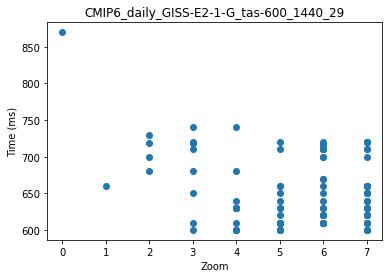

In [9]:
generate_zooms_plot(results_df, collection_name)